# <center>Распознавание речи на основе сравнения с эталоном<center><a class="tocSkip">

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import os
import random
from collections import defaultdict
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import librosa
import faiss
import pickle

**<center>Необходимо реализовать алгоритм распознавания речи на основе сравнения с эталоном<center>**

## DTW

In [2]:
def metric(x1, x2):
    '''Вычислить расстояние'''
    if isinstance(x1, float):
        # Для числовых значений: l1
        return abs(x1 - x2)
    # Для векторов: l2
    return euclidean(x1, x2)

In [3]:
def DTW(arr, ref, back=True, plot=False):
    '''Вычислить оптимальное соответствие между двумя последовательностями
        Параметры:
            arr - входной массив
            ref - эталон
            back - вычислять backtrace
            plot - визуализация результатов
        Возврат из функции:
            Расстояние между последовательностями
            trace (опционально)
    '''
    
    n, m = len(arr), len(ref)
    trace = np.zeros((n, m))
    if back:
        backtrace = np.zeros((n, m), dtype=int)
        shift_points = [[1, 0], [0, 1], [1, 1]]
    
    # Инициализировать матрицу трансформаций
    trace[0, 0] = metric(arr[0], ref[0])
    # Заполнить первую строку
    for j in range(1, m):
        trace[0, j] = trace[0, j - 1] + metric(arr[0], ref[j])
        if back:
            backtrace[0, j] = 1
    # Заполнить первый столбец
    for i in range(1, n):
        trace[i, 0] = trace[i - 1, 0] + metric(arr[i], ref[0])
        if back:
            backtrace[i, 0] = 0
    
    for i in range(1, n):
        for j in range(1, m):
            points = [trace[i - 1, j], trace[i, j - 1], trace[i - 1, j - 1]]
            # вычислить стоимость пути
            trace[i, j] = metric(arr[i], ref[j]) + min(points)
            if back:
                backtrace[i, j] = np.argmin(points)
    
    if back:
        # вычислить путь
        n_dim, m_dim = n, m
        n, m = n - 1, m - 1
        index = [(n, m)]
        while n > 0 or m > 0:
            shift_i, shift_j = shift_points[backtrace[n, m]]
            n, m = n - shift_i, m - shift_j
            index.append((n, m))
        
        if plot:
            hm = np.zeros((n_dim, m_dim))
            for i, j in index:
                hm[i, j] = 1
            plt.figure(figsize=(7, 3))
            sns.heatmap(hm, annot=trace, cbar=None)
        
        return trace[-1,-1], index[::-1]
    
    return trace[-1,-1]

In [ ]:
# Выполним несколько проверок для того, чтобы убедиться, что самописный DTW работает правильно

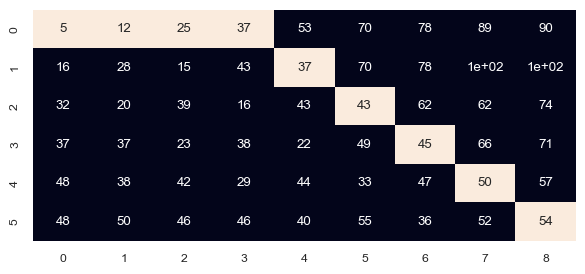

In [4]:
sns.set(font_scale=0.8)
# Пример из лекции
dist, trace = DTW(np.array([3, -13, 14, -7, 9, -2], dtype=float), 
                  np.array([-2, 10, -10, 15, -13, 20, -5, 14, 2], dtype=float), plot=True)

In [5]:
print(dist, trace)

54.0 [(0, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8)]


In [6]:
dist = DTW(np.arange(10, dtype=float), np.arange(5, dtype=float), back=False)

In [7]:
print(dist)

15.0


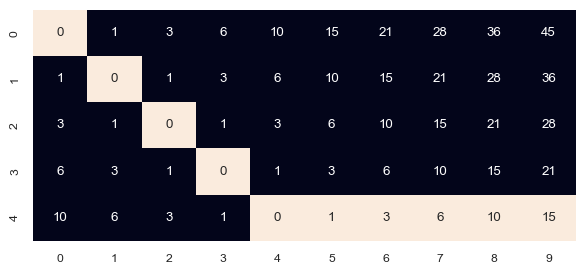

In [8]:
dist, _ = DTW(np.arange(5, dtype=float), np.arange(10, dtype=float), plot=True)

In [9]:
print(dist)

15.0


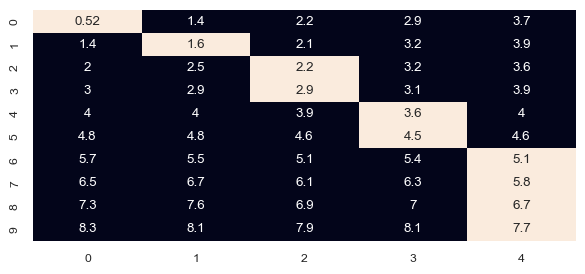

In [10]:
dist, _ = DTW(np.random.random((5, 10)).T, np.random.random((5, 5)).T, plot=True)

In [11]:
DTW(np.random.random((5, 10)).T, np.random.random((5, 5)).T, back=False)

7.6718051869802535

## Формирование набора данных

In [12]:
DATASET_PATH = 'resources/speech_commands_v0.01/'

In [13]:
# Сохраним пути к папкам со словами
words = []

for f in os.listdir(DATASET_PATH):
    dir_ = os.path.join(DATASET_PATH, f)
    if os.path.isdir(dir_):
        words.append(dir_)

In [14]:
# Шум не будем считать за слово
assert len(words) - 1 == 30

In [15]:
# Выберем случайное подмножество слов
audio = random.choices(words, k=10)

In [16]:
assert '_background_noise_' not in audio

In [17]:
# Сохраним слова и их аудиозаписи в словарь 
data = defaultdict(list)
for dir_ in audio:
    for file in os.listdir(dir_):
        data[dir_.split('/')[-1]].append(os.path.join(dir_, file))

In [18]:
# Вычислим классы и их количество данных
classes = defaultdict(int)
for k, v in data.items():
    classes[k] = len(v)
for k, v in classes.items():
    print(k, v, sep='\t')

marvin	3492
no	2375
dog	1746
right	4734
eight	4704
go	2372
seven	2377


In [19]:
# В целом, количество аудиозаписей в наборе примерно одинаковое
# Поэтому объединим все в один набор и поделим на тренировочную и тестовую
# с использованием stratify (навсякий случай)

In [120]:
# Сформировать набор данных в виде DataFrame 
dataset = []
label = []
for k, v in data.items():
    dataset.extend(v)
    label.extend([k] * len(v))
dataset = pd.DataFrame({'audio': dataset, 'word': label})

In [121]:
assert dataset.word.value_counts().to_dict() == classes

In [ ]:
# Дальнейшие эксперименты покажут, что набор для такого способа обучения на ноутбуке большой
# Поэтому случайно выберем лишь небольшое подмножество для обучения

In [122]:
dataset = dataset.sample(frac=.1, replace=False, random_state=2022)
dataset.head()

,audio,word
5509,resources/speech_commands_v0.01/no\d90b4138_no...,no
11992,resources/speech_commands_v0.01/right\db8a3397...,right
11364,resources/speech_commands_v0.01/right\9aa5439d...,right
20834,resources/speech_commands_v0.01/seven\9b402bc2...,seven
18267,resources/speech_commands_v0.01/go\8830e17f_no...,go


In [124]:
# Используем лейбел "N-кодер"
lr = LabelEncoder().fit(dataset.word.values)
Y = lr.transform(dataset.word.values)

In [125]:
# Поделить датасет 
ref_x, test_x, ref_y, test_y = train_test_split(dataset.audio.values, 
                                                Y, 
                                                test_size=.3, 
                                                stratify=Y)

In [126]:
# Вывести размерность массивов
ref_x.shape, test_x.shape

((1526,), (654,))

## Обучение модели

In [ ]:
# Идея:
#  1 этап:
#    - Вычислим матрицу mel = [mfcc_x_time] для каждой тренировочной (эталонной) аудиозаписи (N - количество аудио)
#    - Вычислим квадратную матрицу [N_x_N], которая будет хранить на пересечении строк и столбцов i - j 
#                    расстояния между эталонными образцами с помощью DTW(mel_i^T, mel_j^T)
#    - Сопоставим каждой строке "матрицы расстояний между эталонами" метки слов
#    - Реализуем метрический алгоритм для нахождения ближайших пар векторов (точек в пространстве) 
#  2 этап:
#    - Для выполнения предсказаний посчитаем mel для входных данных 
#    - Вычислим DTW с каждым из эталонов
#    - Подадим на вход метрического алгоритма

In [127]:
class FaissKNeighbors:
    """Заимствованная реализация "быстрого поиска" ближайших соседей"""
    
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [128]:
def train(ref_x=ref_x, ref_y=ref_y, n_mfcc=23):
    '''Обучение модели с DTW'''
    
    n = len(ref_x)
    dist_matrix = np.zeros((n, n))
    
    print('mfcc calculate ...')
    mfccs = []
    for i in range(n):
        x, sr = librosa.load(ref_x[i])
        mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc).T
        mfccs.append(mfcc)
    
    print('dist matrix calculate ...')
    for i in range(n):
        mfcc1 = mfccs[i]
        for j in range(n):
            mfcc2 = mfccs[j]
            dist_matrix[i, j] = DTW(mfcc1, mfcc2, back=False)
        if i % 500 == 0: print(f'{i} iterations')
    
    scaler = StandardScaler().fit(dist_matrix)
    dist_matrix_scale = scaler.transform(dist_matrix)
    print('kNN train ...')
    knn = FaissKNeighbors()
    # knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(dist_matrix_scale, ref_y)
    
    return knn, dist_matrix, mfccs, scaler


def evaluate(test_x=test_x, test_y=test_y, train_len=None, n_mfcc=23, mfccs_train=None, clf=None, scaler=None):
    '''Вычислить производительность модели с DTW'''
    
    n = len(test_x)
    
    print('mfcc calculate ...')
    mfccs_test = []
    for i in range(n):
        x, sr = librosa.load(test_x[i])
        mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc).T
        mfccs_test.append(mfcc)
    
    print('dist matrix calculate ...')
    distance_on_test = []
    for i in range(n):
        mfcc1 = mfccs_test[i]
        dist = []
        for j in range(train_len):
            mfcc2 = mfccs_train[j]
            dist.append(DTW(mfcc1, mfcc2, back=False))
        distance_on_test.append(dist)
        if i % 500 == 0: print(f'{i} iterations')
    
    print('get predict ...')
    predicted = clf.predict(scaler.transform(distance_on_test))
    
    return accuracy_score(test_y, predicted), confusion_matrix(test_y, predicted)


def predict(datum, train_len, n_mfcc, mfccs_train, clf, scaler, le):
    '''Выполнить предсказание'''
    x, sr = librosa.load(datum)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc).T
    dist = []
    for i in range(train_len):
        mfcc_ = mfccs_train[i]
        dist.append(DTW(mfcc, mfcc_, back=False))
    return le.inverse_transform(clf.predict(scaler.transform([dist])))

In [129]:
n_mfcc = 23

In [130]:
%%time

knn, dist_matrix, mfccs, scaler = train(ref_x, ref_y)

mfcc calculate ...
dist matrix calculate ...
0 iterations
500 iterations
1000 iterations
1500 iterations
kNN train ...
CPU times: total: 8h 5min 29s
Wall time: 8h 8min 12s


## Оценка работы

In [131]:
%%time
#  Вычислим производительность модели на тестовой выборке 
acc, cm = evaluate(test_x, test_y, len(ref_x), n_mfcc, mfccs, knn, scaler)

mfcc calculate ...
dist matrix calculate ...
0 iterations
500 iterations
get predict ...
CPU times: total: 3h 27min 21s
Wall time: 3h 27min 19s


In [132]:
# Точность работы модели
print(acc)

0.44648318042813456


In [139]:
# Вывести список классов
lr.classes_

array(['dog', 'eight', 'go', 'marvin', 'no', 'right', 'seven'],
      dtype=object)

In [133]:
# Матрица неточностей для lr.classes_
print(cm)

[[  9   3   8  16   6   4   6]
 [  1 114   3   3   2  21   0]
 [  9   6  21  13  10  11   8]
 [  9  12   8  54   4  10   7]
 [ 10   7  24   6   5   6   6]
 [  6  28  15  18   5  61   5]
 [  9  11   8   8   5   5  28]]


In [ ]:
# Интересное наблюдение: например, в матрице неточностей слово "no" классификатор часто путает со словом "go"

In [134]:
# Вычислим производительность модели на тренировочной выборке 
acc1 = accuracy_score(ref_y, knn.predict(scaler.transform(dist_matrix)))
cm1 = confusion_matrix(ref_y, knn.predict(scaler.transform(dist_matrix)))

In [135]:
# точность 
print(acc1)

0.6697247706422018


In [136]:
# Матрица неточностей для lr.classes_
print(cm1)

[[ 63   5   9  16   9   8  13]
 [  9 296   0   7   4  20   1]
 [ 21  12 113   7  11  11   6]
 [ 11  12   9 188   2  15   6]
 [ 12  12  29  13  68  10   5]
 [ 12  49  12  28  12 204   4]
 [ 14  12  17  16  10  13  90]]


In [155]:
index = 12
lr.inverse_transform([test_y[index]])[0]

'seven'

In [145]:
# Выполним предсказание
datum = test_x[index]
predict(datum, len(ref_x), n_mfcc, mfccs, knn, scaler, lr)

array(['seven'], dtype=object)

## Выводы

In [ ]:
# Данный подход является устаревшим, и на данный момент навряд ли используется (по крайней мере в таком виде)
# Также, такая реализация является очень вычислительно неэффективной (и требует хотя бы параллелизации)
# Cложность DTW - O(n*m), а также для вычисления матрицы попарных расстояний требуется O(n^2)
# Метрики классификации - низкие, необходимо использовать больше данных